In [56]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
from nanodrz import data
import torchaudio
from denoiser import pretrained
from nanodrz.model import DiarizeGPT, Config
from denoiser.demucs import Demucs
import torch


import torch
from nanodrz.utils import play, resample, visualise_annotation

device = torch.cuda.set_device("cuda:1")
denoiser = torch.compile(pretrained.dns64().cpu().eval())
ckpt = torch.load("/home/harry/runs/nanodrz/1708904995/0014000.pt", map_location=device)
config = Config(**ckpt["config"])
model: DiarizeGPT = DiarizeGPT.from_pretrained(ckpt).cuda()


@torch.inference_mode()
def denoise(denoiser, audio, sr=None):
    audio = audio.sum(dim=0, keepdim=True)
    return denoiser.cuda()(audio.cuda()).cpu()

/home/harry/nanodrz/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


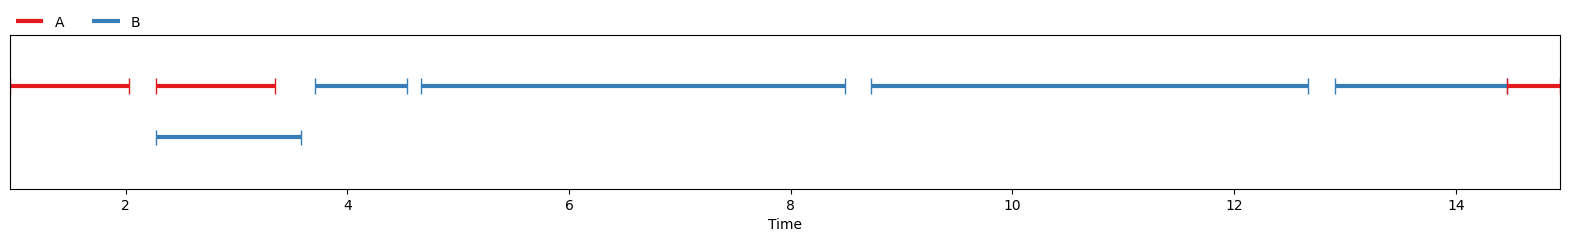

In [55]:
audio, sr = torchaudio.load("/home/harry/test3.wav")
audio = audio.sum(dim=0)[None]
audio = audio / audio.abs().max()
audio = resample(sr, 16000, audio)
sr = 16000
start = sr*5
audio = audio[:, int(start): int(start+15*sr)]
audio = denoise(denoiser.cuda(), audio)
nlabels = model.generate(audio.cuda(), temperature=.3, max_steps=4*6)
visualise_annotation(nlabels)
play(audio)